In [ ]:
!pip install scipy==1.11.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.3/36.3 MB 15.4 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.11.4
    Uninstalling scipy-1.11.4:
      Successfully uninstalled scipy-1.11.4


In [ ]:
from keras.layers import Input, Dense, Conv2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.utils import to_categorical
from keras import backend as K
from keras.callbacks import Callback
import tensorflow as tf

from scipy.stats import entropy
from scipy.linalg import sqrtm
from scipy.stats import pearsonr

from keras.applications.inception_v3 import InceptionV3

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.models import load_model

import cv2

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import entropy
from scipy.spatial.distance import cosine

import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from scipy.linalg import sqrtm

In [ ]:
import random

seed = 42

# Python's built-in random library
random.seed(seed)

# Scikit-learn (only affects some parts of scikit-learn)
from sklearn.utils import check_random_state
check_random_state(seed)

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [ ]:
img_rows = 168
img_cols = 168
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

In [ ]:
# Set path for data source
import os
from google.colab import drive
drive.mount('/content/gdrive')
os.chdir("/content/gdrive/My Drive/Load Diffusion/dataset/")

Mounted at /content/gdrive


In [ ]:
# Set the path to the folder containing saved files
load_path = "./preprocessed_data_168x168_2years"

# Load saved NumPy arrays
X_train = np.load(os.path.join(load_path, 'X_train.npy'))
X_test = np.load(os.path.join(load_path, 'X_test.npy'))
y_train = np.load(os.path.join(load_path, 'y_train.npy'))
y_test = np.load(os.path.join(load_path, 'y_test.npy'))

# Load saved Pandas DataFrames
train_data = pd.read_pickle(os.path.join(load_path, 'train_data.pkl'))
test_data = pd.read_pickle(os.path.join(load_path, 'test_data.pkl'))
metadata = pd.read_pickle(os.path.join(load_path, 'metadata.pkl'))
metadata_original = pd.read_pickle(os.path.join(load_path, 'metadata_original.pkl'))

In [ ]:
def merge_dummified_columns(df, dummified_columns, new_column_name):
    """
    Merges dummified columns into a single column in a DataFrame.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the dummified columns.
        dummified_columns (list): A list of the names of the dummified columns.
        new_column_name (str): The name of the new column to create.

    Returns:
        pd.DataFrame: The DataFrame with the dummified columns merged into a single new column.
    """
    # Create a new column containing the column name where the value is 1 for each row
    df[new_column_name] = df[dummified_columns].idxmax(axis=1)

    # Drop the dummified columns
    df.drop(dummified_columns, axis=1, inplace=True)

    return df

test_metadata = metadata_original.loc[test_data.columns]

test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['chilledwater', 'electricity', 'gas', 'hotwater', 'steam'],
                     new_column_name='meter_type')
test_metadata = merge_dummified_columns(test_metadata,
                     dummified_columns=['Education', 'Entertainment/public assembly', 'Lodging/residential', 'Office', 'Public services'],
                     new_column_name='building_type')

test_metadata


,lat,lng,year,meter_type,building_type
electricity_Lamb_office_Caitlin_2016,51.497838,-3.186246,2016,electricity,Office
electricity_Rat_public_Kelle_2016,38.903504,-77.005349,2016,electricity,Public services
electricity_Rat_assembly_Ezequiel_2016,38.903504,-77.005349,2016,electricity,Entertainment/public assembly
electricity_Bear_assembly_Roxy_2016,37.871903,-122.260729,2016,electricity,Entertainment/public assembly
gas_Shrew_office_Rose_2017,51.499840,-0.124663,2017,gas,Office
...,...,...,...,...,...
steam_Moose_education_Omar_2016,45.421500,-75.697200,2016,steam,Education
electricity_Rat_public_Chrissy_2017,38.903504,-77.005349,2017,electricity,Public services
electricity_Hog_office_Merilyn_2016,44.978782,-93.255398,2016,electricity,Office
steam_Bull_assembly_Amalia_2016,30.267200,-97.743100,2016,steam,Entertainment/public assembly


In [ ]:
def calculate_rmse(true_data, predicted_data):
    return np.sqrt(mean_squared_error(true_data, predicted_data))

def calculate_mae(true_data, predicted_data):
    return mean_absolute_error(true_data, predicted_data)

def calculate_r2(true_data, predicted_data):
    return r2_score(true_data, predicted_data)

def calculate_kl_divergence(true_data, predicted_data):
    return entropy(true_data+0.00000001, predicted_data+0.00000001)

def calculate_cosine_similarity(true_data, predicted_data):
    return 1 - cosine(true_data, predicted_data)

In [ ]:
def evaluate_model(test_series, generated_series):
    metrics_result = {
        'rmse': [],
        'mae': [],
        'r2': [],
        'kl_divergence': [],
        'cosine_similarity': [],
        'pearson_correlation': []
    }

    for i in range(test_series.shape[1]):
        try:
            true_data = test_series[:, i]
            predicted_data = generated_series[:, i]
        except:
            true_data = test_series.values[:, i]
            predicted_data = generated_series.values[:, i]

        # Calculate Pearson correlation
        pearson_corr, _ = pearsonr(true_data, predicted_data)

        metrics_result['rmse'].append(calculate_rmse(true_data, predicted_data))
        metrics_result['mae'].append(calculate_mae(true_data, predicted_data))
        metrics_result['r2'].append(calculate_r2(true_data, predicted_data))
        metrics_result['kl_divergence'].append(calculate_kl_divergence(true_data, predicted_data))
        metrics_result['cosine_similarity'].append(calculate_cosine_similarity(true_data, predicted_data))
        metrics_result['pearson_correlation'].append(pearson_corr)

    return metrics_result

# Function to calculate FID between two sets of images
def calculate_fid(model, images1, images2):
    # Calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)

    # Calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)

    # Calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)

    # Calculate sqrt of product between covariances
    covmean = sqrtm(sigma1.dot(sigma2))

    # Check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    # Calculate the FID score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [ ]:
# Initialize an empty DataFrame to store metrics
df_metrics = []

for model_name in ['CVAE_mse','CGAN','diffusion_model']:

  # Specify the path where the datasets are saved
  generation_path = "./generation/" + model_name + '_168x168'

  for file_name in [file for file in os.listdir(generation_path) if "epoch" in file]:
    # Load the dataset
    print(model_name+' / '+file_name)

CVAE_mse / generated_epochs_10_test.npy
CVAE_mse / generated_epochs_15_test.npy
CVAE_mse / generated_epochs_30_test.npy
CVAE_mse / generated_epochs_50_test.npy
CVAE_mse / generated_epochs_55_test.npy
CVAE_mse / generated_epochs_65_test.npy
CVAE_mse / generated_epochs_75_test.npy
CVAE_mse / generated_epochs_45_test.npy
CVAE_mse / generated_epochs_70_test.npy
CVAE_mse / generated_epochs_40_test.npy
CVAE_mse / generated_epochs_85_test.npy
CVAE_mse / generated_epochs_90_test.npy
CVAE_mse / generated_epochs_60_test.npy
CVAE_mse / generated_epochs_35_test.npy
CVAE_mse / generated_epochs_100_test.npy
CVAE_mse / generated_epochs_95_test.npy
CVAE_mse / generated_epochs_25_test.npy
CVAE_mse / generated_epochs_5_test.npy
CVAE_mse / generated_epochs_80_test.npy
CVAE_mse / generated_epochs_20_test.npy
CVAE_mse / generated_epochs_5_train.npy
CVAE_mse / generated_epochs_10_train.npy
CVAE_mse / generated_epochs_15_train.npy
CVAE_mse / generated_epochs_20_train.npy
CVAE_mse / generated_epochs_25_train.

In [ ]:
# Initialize an empty DataFrame to store metrics
df_metrics = []

for model_name in ['CVAE_mse','CGAN','diffusion_model']:

  # Specify the path where the datasets are saved
  generation_path = "./generation/" + model_name + '_168x168'

  for file_name in [file for file in os.listdir(generation_path) if "epoch" in file]:
    # Load the dataset
    print(model_name+' / '+file_name)
    generated_images = np.load(os.path.join(generation_path, file_name))
    data_type = file_name.split('.')[0].split('_')[-1]
    images_seed = int(file_name.split('.')[0].split('_')[-2])

    # Set the target shape
    target_shape = (generated_images.shape[0], 52, 168, 1)

    # Initialize an array to hold the resized images
    resized_images = np.zeros(target_shape)

    # Loop through each image to resize it
    for i in range(generated_images.shape[0]):
        resized_image = cv2.resize(generated_images[i], (168, 52))  # Note the dimensions are (width, height)
        resized_images[i] = np.expand_dims(resized_image, axis=-1)  # Add back the last dimension

    # Assume resized_images has a shape of (905, 52, 168, 1)
    flattened_images = resized_images.reshape(generated_images.shape[0], -1).T  # Transpose to get shape (8736, generated_images.shape[0])

    if data_type == 'test':
      ground_truth = test_data.copy()
    else:
      ground_truth = train_data.iloc[:, ::3].copy()

    generated_series = pd.DataFrame(flattened_images)
    generated_series.columns = ground_truth.columns

    generated_series = (generated_series-generated_series.min())/(generated_series.max()-generated_series.min())
    ground_truth = (ground_truth-ground_truth.min())/(ground_truth.max()-ground_truth.min())

    ground_truth_resampled = ground_truth.rolling(24).mean()[23::24]
    generated_series_resampled = generated_series.rolling(24).mean()[23::24]

    evaluation_results = evaluate_model(ground_truth, generated_series)
    evaluation_results_resampled = evaluate_model(ground_truth_resampled, generated_series_resampled)

    df_evaluation_results = pd.DataFrame(evaluation_results)
    df_evaluation_results_resampled = pd.DataFrame(evaluation_results_resampled)
    df_evaluation_results_resampled.columns = df_evaluation_results_resampled.columns+'_daily_avg'

    # Prepare the Inception v3 model
    model = InceptionV3(include_top=False, pooling='avg', weights="imagenet", input_shape=(99,99,3))

    # Convert to RGB and upscale to the necessary input size for the Inception model
    X_test_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(X_test))
    generated_images_rgb = tf.image.grayscale_to_rgb(tf.convert_to_tensor(generated_images))

    X_test_upscaled = tf.image.resize(X_test_rgb, [99, 99])
    generated_images_upscaled = tf.image.resize(generated_images_rgb, [99, 99])

    # Calculate FID
    fid_score = calculate_fid(model, X_test_upscaled, generated_images_upscaled)

    metrics = pd.concat([df_evaluation_results.mean(), df_evaluation_results_resampled.mean()])
    metrics['fid_score'] = fid_score
    metrics['epochs'] = images_seed
    metrics['model'] = model_name
    metrics['dataset'] = data_type
    metrics = metrics.to_frame().T
    display(metrics)

    # Append the metrics to df_metrics
    df_metrics.append(metrics)

CVAE_mse / generated_epochs_10_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.348501,0.285988,-7.094048,0.467821,0.766366,0.309196,0.284095,0.247495,-99.596522,0.297232,0.835929,0.249939,1679.001356,10.0,CVAE_mse,test


CVAE_mse / generated_epochs_15_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.294638,0.239089,-3.912321,0.493004,0.755981,0.31572,0.224702,0.19215,-48.268676,0.298798,0.835332,0.261038,1680.526182,15.0,CVAE_mse,test


CVAE_mse / generated_epochs_30_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.289339,0.237323,-3.959682,0.466446,0.768324,0.325537,0.227653,0.195734,-53.343033,0.290707,0.840145,0.273993,1488.437033,30.0,CVAE_mse,test


CVAE_mse / generated_epochs_50_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.273025,0.225325,-4.154002,0.444927,0.777572,0.336946,0.222151,0.190189,-66.157444,0.285852,0.843034,0.298453,1306.634367,50.0,CVAE_mse,test


CVAE_mse / generated_epochs_55_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.275014,0.227244,-4.128806,0.440946,0.779779,0.341119,0.223216,0.191908,-64.634251,0.28242,0.845261,0.303502,1277.937598,55.0,CVAE_mse,test


CVAE_mse / generated_epochs_65_test.npy
29/29 [==============================] - 0s 15ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.26599,0.218674,-4.162953,0.441933,0.779076,0.346516,0.214887,0.183114,-69.047535,0.28218,0.845286,0.31554,1195.391289,65.0,CVAE_mse,test


CVAE_mse / generated_epochs_75_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.261712,0.2145,-4.169208,0.440543,0.778663,0.351967,0.210899,0.179091,-71.821572,0.281909,0.845221,0.326198,1153.145441,75.0,CVAE_mse,test


CVAE_mse / generated_epochs_45_test.npy
29/29 [==============================] - 0s 15ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.283345,0.234879,-4.556671,0.444227,0.778875,0.33348,0.232017,0.200009,-70.86698,0.286391,0.843315,0.291671,1338.260809,45.0,CVAE_mse,test


CVAE_mse / generated_epochs_70_test.npy
29/29 [==============================] - 0s 16ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.266967,0.21922,-4.457538,0.443348,0.778676,0.350655,0.215973,0.183926,-75.884937,0.28362,0.844821,0.31878,1223.61654,70.0,CVAE_mse,test


CVAE_mse / generated_epochs_40_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.282672,0.233252,-4.126016,0.454329,0.773538,0.325913,0.226897,0.195296,-60.551042,0.287362,0.841806,0.278951,1412.091846,40.0,CVAE_mse,test


CVAE_mse / generated_epochs_85_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.25922,0.212416,-4.024215,0.445634,0.776492,0.350828,0.208669,0.177201,-69.894096,0.284791,0.844153,0.326785,1069.975382,85.0,CVAE_mse,test


CVAE_mse / generated_epochs_90_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.257509,0.210605,-3.696124,0.446196,0.776219,0.356353,0.207273,0.175517,-62.958196,0.285463,0.843807,0.334975,1049.670301,90.0,CVAE_mse,test


CVAE_mse / generated_epochs_60_test.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.269257,0.220774,-4.064866,0.444062,0.778893,0.349729,0.216638,0.184544,-64.27205,0.282553,0.845629,0.320463,1270.139655,60.0,CVAE_mse,test


CVAE_mse / generated_epochs_35_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.284234,0.233292,-4.203571,0.462024,0.770186,0.327691,0.226305,0.19407,-60.718977,0.291763,0.840012,0.281978,1417.014774,35.0,CVAE_mse,test


CVAE_mse / generated_epochs_100_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.258466,0.21079,-3.969388,0.455561,0.772334,0.351359,0.207696,0.175321,-69.883774,0.29105,0.840831,0.331587,943.89993,100.0,CVAE_mse,test


CVAE_mse / generated_epochs_95_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.259718,0.211778,-3.704891,0.454046,0.773228,0.353689,0.208166,0.176016,-62.592572,0.289106,0.841874,0.332084,972.902918,95.0,CVAE_mse,test


CVAE_mse / generated_epochs_25_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.289245,0.236319,-3.904725,0.47326,0.764138,0.321294,0.22529,0.193381,-50.296801,0.294091,0.838079,0.26825,1526.791068,25.0,CVAE_mse,test


CVAE_mse / generated_epochs_5_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.352418,0.293125,-7.869878,0.469168,0.7605,0.240168,0.311066,0.266862,-125.81228,0.320069,0.817713,0.163323,1593.633465,5.0,CVAE_mse,test


CVAE_mse / generated_epochs_80_test.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.261012,0.213603,-4.421242,0.447417,0.775766,0.350187,0.210556,0.1786,-77.750246,0.286726,0.843033,0.325007,1092.916058,80.0,CVAE_mse,test


CVAE_mse / generated_epochs_20_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.293961,0.239287,-3.715452,0.482044,0.759909,0.319786,0.226482,0.194148,-45.260302,0.296268,0.83688,0.268354,1633.228144,20.0,CVAE_mse,test


CVAE_mse / generated_epochs_5_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.342653,0.284621,-2.375908,0.427119,0.776288,0.284284,0.301849,0.25855,-5.095875,0.294974,0.830218,0.208253,1592.477255,5.0,CVAE_mse,train


CVAE_mse / generated_epochs_10_train.npy
29/29 [==============================] - 0s 15ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.339003,0.277734,-2.312404,0.426012,0.780424,0.341524,0.276292,0.2406,-3.961773,0.276238,0.845579,0.282497,1678.652948,10.0,CVAE_mse,train


CVAE_mse / generated_epochs_15_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.288434,0.233944,-1.382221,0.453155,0.769031,0.344904,0.220828,0.189073,-2.104275,0.27945,0.843852,0.286506,1685.519887,15.0,CVAE_mse,train


CVAE_mse / generated_epochs_20_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.287217,0.233655,-1.376603,0.441848,0.773311,0.34879,0.222276,0.190545,-2.207896,0.276579,0.845588,0.29301,1637.439834,20.0,CVAE_mse,train


CVAE_mse / generated_epochs_25_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.282892,0.231033,-1.305449,0.43511,0.776873,0.349537,0.221341,0.190013,-2.17437,0.275413,0.846435,0.294347,1526.746308,25.0,CVAE_mse,train


CVAE_mse / generated_epochs_30_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.282835,0.231778,-1.315009,0.429094,0.780506,0.351287,0.223087,0.191833,-2.315427,0.272583,0.84818,0.296228,1490.507148,30.0,CVAE_mse,train


CVAE_mse / generated_epochs_35_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.277332,0.227344,-1.215619,0.423829,0.782804,0.355218,0.221528,0.189774,-2.172962,0.273233,0.848316,0.304108,1420.349935,35.0,CVAE_mse,train


CVAE_mse / generated_epochs_40_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.275335,0.226991,-1.193957,0.417254,0.78593,0.352812,0.221055,0.190179,-2.263066,0.26844,0.850595,0.302629,1410.334931,40.0,CVAE_mse,train


CVAE_mse / generated_epochs_45_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.275665,0.228188,-1.199922,0.406431,0.791482,0.36053,0.225993,0.19472,-2.382781,0.267564,0.851794,0.314772,1342.856821,45.0,CVAE_mse,train


CVAE_mse / generated_epochs_50_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.265814,0.219229,-1.028351,0.406429,0.790451,0.365084,0.216645,0.185456,-2.01939,0.266738,0.851657,0.323601,1307.418781,50.0,CVAE_mse,train


CVAE_mse / generated_epochs_55_train.npy
29/29 [==============================] - 0s 12ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.26847,0.221609,-1.077539,0.404681,0.791658,0.365789,0.218047,0.187078,-2.117321,0.264465,0.853312,0.324995,1276.684885,55.0,CVAE_mse,train


CVAE_mse / generated_epochs_60_train.npy
29/29 [==============================] - 0s 16ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.263574,0.216193,-0.996549,0.409826,0.789798,0.37287,0.212326,0.180573,-1.90651,0.265948,0.852838,0.339596,1271.993089,60.0,CVAE_mse,train


CVAE_mse / generated_epochs_65_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.259637,0.213365,-0.941403,0.406212,0.791099,0.373005,0.209796,0.178571,-1.880687,0.264826,0.853436,0.342691,1194.437208,65.0,CVAE_mse,train


CVAE_mse / generated_epochs_70_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.261628,0.214896,-0.965836,0.409024,0.789849,0.375127,0.211585,0.179948,-1.890834,0.267832,0.851985,0.342338,1226.365525,70.0,CVAE_mse,train


CVAE_mse / generated_epochs_75_train.npy
29/29 [==============================] - 0s 15ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.256088,0.209746,-0.88196,0.404568,0.790987,0.381522,0.20655,0.174985,-1.754279,0.264837,0.853133,0.353287,1150.150414,75.0,CVAE_mse,train


CVAE_mse / generated_epochs_80_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.255477,0.208921,-0.8766,0.411172,0.788068,0.378415,0.206033,0.174332,-1.750288,0.269228,0.851183,0.352659,1092.124873,80.0,CVAE_mse,train


CVAE_mse / generated_epochs_85_train.npy
29/29 [==============================] - 0s 15ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.253336,0.207042,-0.842524,0.408734,0.788724,0.378447,0.203755,0.172256,-1.675572,0.267154,0.851971,0.353469,1068.663698,85.0,CVAE_mse,train


CVAE_mse / generated_epochs_90_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.251719,0.205379,-0.827599,0.410962,0.787717,0.382525,0.202141,0.170486,-1.667531,0.267728,0.851527,0.35979,1049.601456,90.0,CVAE_mse,train


CVAE_mse / generated_epochs_95_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.254369,0.206906,-0.866658,0.418506,0.784652,0.37929,0.203473,0.171395,-1.698649,0.271065,0.849667,0.356139,978.335117,95.0,CVAE_mse,train


CVAE_mse / generated_epochs_100_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.253209,0.206229,-0.851268,0.419087,0.784416,0.379344,0.203055,0.171064,-1.698488,0.271848,0.849267,0.360233,961.568266,100.0,CVAE_mse,train


CGAN / generated_epochs_1000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.350252,0.296973,-6.430508,0.745545,0.700952,-0.017133,0.289347,0.249064,-92.879649,0.394004,0.791835,-0.059206,3009.60782,1000.0,CGAN,test


CGAN / generated_epochs_2000_test.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.307619,0.249081,-4.126319,0.831316,0.660435,0.065876,0.253128,0.207777,-57.153205,0.49016,0.750888,0.093125,2131.523121,2000.0,CGAN,test


CGAN / generated_epochs_3000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.334899,0.268416,-4.732191,2.488606,0.586909,0.107556,0.270602,0.221948,-53.74228,1.198832,0.68444,0.033027,1579.222831,3000.0,CGAN,test


CGAN / generated_epochs_4000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.289745,0.23207,-3.682563,0.692899,0.685081,0.100406,0.244235,0.200481,-53.651939,0.443465,0.759816,0.050349,1371.763442,4000.0,CGAN,test


CGAN / generated_epochs_5000_test.npy
29/29 [==============================] - 1s 18ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.335412,0.27245,-6.371614,0.976185,0.668845,0.117265,0.289286,0.240358,-97.34606,0.605097,0.739513,0.070584,1544.706475,5000.0,CGAN,test


CGAN / generated_epochs_6000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.390768,0.32089,-7.395095,0.789534,0.665096,-0.015723,0.261931,0.226621,-79.498991,0.319503,0.818588,-0.051605,3084.577253,6000.0,CGAN,test


CGAN / generated_epochs_7000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.356257,0.28279,-4.949607,1.345686,0.591145,0.022788,0.231742,0.191743,-40.220431,0.41052,0.776731,0.024814,2594.346867,7000.0,CGAN,test


CGAN / generated_epochs_8000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.266346,0.206316,-2.273517,0.760995,0.713921,0.289297,0.210505,0.169868,-26.193047,0.423435,0.805789,0.312067,1235.851799,8000.0,CGAN,test


CGAN / generated_epochs_9000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.339813,0.27365,-4.900041,1.286873,0.72739,0.219209,0.292564,0.23955,-58.454398,0.751634,0.799848,0.218468,1439.907756,9000.0,CGAN,test


CGAN / generated_epochs_10000_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.258897,0.20305,-2.317542,0.748629,0.751188,0.350623,0.206797,0.167861,-30.205513,0.427222,0.829199,0.369874,1027.557073,10000.0,CGAN,test


CGAN / generated_epochs_11000_test.npy
29/29 [==============================] - 1s 16ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.26536,0.209,-2.461961,0.98962,0.749469,0.325916,0.217278,0.175999,-32.706952,0.612989,0.820557,0.330291,962.751934,11000.0,CGAN,test


CGAN / generated_epochs_12000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.268615,0.210646,-2.435893,1.274593,0.731042,0.311539,0.223626,0.180872,-31.527932,0.820032,0.798023,0.300466,868.196585,12000.0,CGAN,test


CGAN / generated_epochs_13000_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.262698,0.205316,-2.41662,0.790652,0.747134,0.339572,0.210879,0.170753,-32.314499,0.47214,0.823316,0.352786,860.167181,13000.0,CGAN,test


CGAN / generated_epochs_14000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.27468,0.215386,-2.642123,1.145609,0.736855,0.320659,0.227893,0.184494,-34.18328,0.73359,0.803965,0.314754,809.764923,14000.0,CGAN,test


CGAN / generated_epochs_15000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.263774,0.206263,-2.492982,0.825731,0.749728,0.333362,0.213105,0.172265,-34.131744,0.500313,0.821998,0.329621,859.104602,15000.0,CGAN,test


CGAN / generated_epochs_16000_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.266936,0.208033,-2.523189,0.850776,0.74209,0.330211,0.216724,0.174694,-33.393589,0.5162,0.814148,0.323147,816.561235,16000.0,CGAN,test


CGAN / generated_epochs_2000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.307073,0.248684,-1.582274,0.791685,0.669979,0.080445,0.25197,0.207012,-2.883362,0.470092,0.758996,0.112498,2145.226055,2000.0,CGAN,train


CGAN / generated_epochs_3000_train.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.335488,0.269468,-2.154799,2.441365,0.594189,0.115526,0.271704,0.223588,-3.68596,1.174804,0.690141,0.032654,1571.344041,3000.0,CGAN,train


CGAN / generated_epochs_1000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.347654,0.294237,-2.326515,0.70932,0.708727,-0.011875,0.285318,0.245079,-4.210777,0.375478,0.798762,-0.053984,3040.608522,1000.0,CGAN,train


CGAN / generated_epochs_4000_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.289859,0.232547,-1.333784,0.657528,0.692794,0.107027,0.244512,0.201503,-2.760831,0.426349,0.765038,0.048514,1374.612116,4000.0,CGAN,train


CGAN / generated_epochs_5000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.33398,0.271647,-2.147889,0.929075,0.676512,0.119348,0.288232,0.239909,-4.400495,0.585503,0.74435,0.064849,1550.080779,5000.0,CGAN,train


CGAN / generated_epochs_6000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.388868,0.319344,-3.163336,0.758208,0.671726,-0.015311,0.25755,0.222192,-3.234935,0.301799,0.825424,-0.04872,3085.96272,6000.0,CGAN,train


CGAN / generated_epochs_7000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.356375,0.283409,-2.486108,1.309855,0.599496,0.032231,0.230915,0.191127,-2.168179,0.390715,0.785622,0.046381,2596.797632,7000.0,CGAN,train


CGAN / generated_epochs_8000_train.npy
29/29 [==============================] - 1s 19ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.266649,0.207706,-1.053622,0.734457,0.726297,0.310112,0.211166,0.171207,-2.007524,0.408789,0.815878,0.329023,1215.521688,8000.0,CGAN,train


CGAN / generated_epochs_9000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.339828,0.274505,-2.373708,1.235717,0.736035,0.227028,0.29214,0.239828,-4.984124,0.731792,0.807509,0.22324,1441.744217,9000.0,CGAN,train


CGAN / generated_epochs_10000_train.npy
29/29 [==============================] - 1s 18ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.26142,0.206439,-0.990208,0.726192,0.7594,0.35971,0.209853,0.171369,-2.069968,0.419486,0.835607,0.374677,1007.567312,10000.0,CGAN,train


CGAN / generated_epochs_11000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.267609,0.212023,-1.067432,0.955683,0.755905,0.333549,0.219212,0.178557,-2.286899,0.598967,0.826052,0.338015,946.407902,11000.0,CGAN,train


CGAN / generated_epochs_12000_train.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.271957,0.21458,-1.127851,1.235559,0.737357,0.318361,0.227396,0.184933,-2.469554,0.804886,0.802555,0.30149,850.713755,12000.0,CGAN,train


CGAN / generated_epochs_13000_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.264987,0.208576,-1.030014,0.785523,0.752053,0.343785,0.21389,0.174293,-2.119513,0.477129,0.826119,0.3523,848.854073,13000.0,CGAN,train


CGAN / generated_epochs_14000_train.npy
29/29 [==============================] - 1s 18ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.276337,0.218159,-1.21386,1.114751,0.743221,0.328105,0.229968,0.187134,-2.616228,0.72197,0.808889,0.320508,784.574992,14000.0,CGAN,train


CGAN / generated_epochs_15000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.265377,0.208877,-1.037279,0.821228,0.755438,0.340222,0.215158,0.174813,-2.194937,0.506907,0.825949,0.333386,842.135502,15000.0,CGAN,train


CGAN / generated_epochs_16000_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.268441,0.210811,-1.096736,0.852833,0.748177,0.33743,0.218787,0.177441,-2.346607,0.527418,0.818503,0.32784,802.147252,16000.0,CGAN,train


diffusion_model / generated_epochs_50_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.258539,0.206828,-0.921393,0.440959,0.774018,0.349749,0.214212,0.175732,-2.053272,0.290673,0.83703,0.311336,667.0797,50.0,diffusion_model,train


diffusion_model / generated_epochs_100_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.26436,0.216658,-1.074911,0.394794,0.799963,0.377734,0.221099,0.185388,-2.576075,0.25492,0.860042,0.356961,681.721493,100.0,diffusion_model,train


diffusion_model / generated_epochs_150_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.252059,0.201727,-0.866138,0.390126,0.800077,0.427647,0.208015,0.171402,-1.998233,0.253816,0.85941,0.411228,645.510737,150.0,diffusion_model,train


diffusion_model / generated_epochs_200_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.25647,0.206279,-0.925892,0.401576,0.794189,0.400904,0.211009,0.174763,-2.078203,0.258157,0.857482,0.399985,745.531628,200.0,diffusion_model,train


diffusion_model / generated_epochs_250_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.249122,0.202694,-0.830157,0.377397,0.807533,0.412389,0.20415,0.170248,-2.023081,0.237353,0.870601,0.425595,767.92715,250.0,diffusion_model,train


diffusion_model / generated_epochs_300_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.251181,0.203956,-0.864432,0.389755,0.803093,0.426502,0.202632,0.169888,-1.930637,0.240907,0.869209,0.43518,610.673633,300.0,diffusion_model,train


diffusion_model / generated_epochs_50_test.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.258488,0.206732,-2.527302,0.47105,0.766397,0.344036,0.21383,0.175012,-35.940612,0.304628,0.831919,0.31889,680.816037,50.0,diffusion_model,test


diffusion_model / generated_epochs_100_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.265937,0.218171,-4.074975,0.423615,0.792888,0.375661,0.222372,0.186642,-69.183958,0.266006,0.857488,0.3715,693.365412,100.0,diffusion_model,test


diffusion_model / generated_epochs_150_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.254251,0.203933,-3.288158,0.424013,0.791007,0.411699,0.209384,0.172534,-54.649169,0.268911,0.85447,0.409889,652.151583,150.0,diffusion_model,test


diffusion_model / generated_epochs_200_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.255242,0.20497,-3.484653,0.42494,0.790576,0.402478,0.209511,0.172971,-58.881899,0.267378,0.855895,0.41278,745.882449,200.0,diffusion_model,test


diffusion_model / generated_epochs_250_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.25089,0.203931,-2.911056,0.407345,0.798661,0.394651,0.205234,0.171221,-46.402451,0.250672,0.865386,0.42038,780.002375,250.0,diffusion_model,test


diffusion_model / generated_epochs_300_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.253818,0.205439,-3.731336,0.422633,0.793083,0.400016,0.204638,0.17062,-62.01433,0.258593,0.861577,0.412757,615.782311,300.0,diffusion_model,test


diffusion_model / generated_epochs_350_test.npy
29/29 [==============================] - 1s 20ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.252842,0.204521,-2.73172,0.414784,0.796527,0.414874,0.206559,0.172409,-41.715525,0.254431,0.863875,0.43372,635.626869,350.0,diffusion_model,test


diffusion_model / generated_epochs_400_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.25279,0.205444,-3.943942,0.404686,0.802026,0.421398,0.205583,0.172108,-66.872913,0.244349,0.869401,0.443204,525.829386,400.0,diffusion_model,test


diffusion_model / generated_epochs_450_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.255084,0.206829,-3.23097,0.421129,0.794135,0.395382,0.208903,0.174354,-53.417538,0.261648,0.860555,0.416253,575.362278,450.0,diffusion_model,test


diffusion_model / generated_epochs_500_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.256937,0.211378,-4.265868,0.415767,0.79666,0.393759,0.212565,0.180074,-76.074208,0.261831,0.860382,0.397616,671.605784,500.0,diffusion_model,test


diffusion_model / generated_epochs_550_test.npy
29/29 [==============================] - 1s 19ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.251941,0.205324,-3.303774,0.412963,0.800437,0.411295,0.20659,0.173472,-50.114462,0.258268,0.864521,0.42992,541.236269,550.0,diffusion_model,test


diffusion_model / generated_epochs_600_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.246928,0.2013,-3.224054,0.407118,0.802352,0.422724,0.202361,0.169225,-55.483795,0.252945,0.866428,0.449669,497.407403,600.0,diffusion_model,test


diffusion_model / generated_epochs_650_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.250203,0.205976,-4.351771,0.404866,0.803957,0.415814,0.207048,0.175513,-81.730049,0.25441,0.865845,0.433764,536.508052,650.0,diffusion_model,test


diffusion_model / generated_epochs_700_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.246699,0.201497,-3.411427,0.403221,0.803099,0.429451,0.20335,0.170873,-59.178758,0.2534,0.865155,0.449399,503.158203,700.0,diffusion_model,test


diffusion_model / generated_epochs_750_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.24932,0.204793,-3.200934,0.401716,0.804295,0.408315,0.206136,0.174492,-51.519018,0.250743,0.867521,0.437482,577.697778,750.0,diffusion_model,test


diffusion_model / generated_epochs_800_test.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.246933,0.202151,-2.712384,0.399866,0.805249,0.420747,0.203594,0.171419,-43.093192,0.25078,0.866947,0.435328,558.957952,800.0,diffusion_model,test


diffusion_model / generated_epochs_850_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.248779,0.203789,-3.629021,0.40079,0.805142,0.427874,0.204976,0.173562,-59.499425,0.252523,0.865844,0.442888,504.14362,850.0,diffusion_model,test


diffusion_model / generated_epochs_900_test.npy
29/29 [==============================] - 1s 19ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.248359,0.203499,-3.04773,0.402782,0.803634,0.413302,0.203312,0.171718,-52.091811,0.25236,0.866631,0.433979,555.899551,900.0,diffusion_model,test


diffusion_model / generated_epochs_950_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.24502,0.200454,-2.74127,0.403474,0.803669,0.425817,0.20106,0.169889,-45.74421,0.253301,0.865284,0.445783,520.369053,950.0,diffusion_model,test


diffusion_model / generated_epochs_1000_test.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.245988,0.201823,-3.491786,0.400215,0.805007,0.422307,0.202025,0.170724,-62.252534,0.251402,0.86655,0.44082,511.392301,1000.0,diffusion_model,test


diffusion_model / generated_epochs_350_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.251244,0.203272,-0.874461,0.381724,0.805914,0.423252,0.205124,0.171162,-2.143167,0.240005,0.868939,0.427631,620.18183,350.0,diffusion_model,train


diffusion_model / generated_epochs_400_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.253038,0.205674,-0.891915,0.377565,0.80821,0.431915,0.207427,0.173956,-2.032441,0.235608,0.871358,0.437056,529.861489,400.0,diffusion_model,train


diffusion_model / generated_epochs_450_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.2534,0.204924,-0.909041,0.385982,0.80257,0.402063,0.207192,0.172832,-2.122388,0.243005,0.866125,0.406703,553.771088,450.0,diffusion_model,train


diffusion_model / generated_epochs_500_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.256049,0.210371,-0.940949,0.385171,0.805452,0.40229,0.210585,0.178209,-2.233858,0.246047,0.867372,0.406112,656.76392,500.0,diffusion_model,train


diffusion_model / generated_epochs_550_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.252168,0.205909,-0.905996,0.381116,0.808032,0.421651,0.208304,0.175147,-2.067021,0.244936,0.867788,0.423952,530.550055,550.0,diffusion_model,train


diffusion_model / generated_epochs_600_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.247807,0.201676,-0.839027,0.381941,0.806347,0.423731,0.203737,0.17035,-2.162906,0.241695,0.868351,0.437482,498.35389,600.0,diffusion_model,train


diffusion_model / generated_epochs_650_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.246156,0.202375,-0.808273,0.367202,0.815898,0.440697,0.203597,0.172046,-2.084184,0.234899,0.874199,0.447311,513.111058,650.0,diffusion_model,train


diffusion_model / generated_epochs_700_train.npy
29/29 [==============================] - 0s 13ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.244004,0.198978,-0.808024,0.366037,0.814402,0.44425,0.201081,0.169004,-2.160595,0.23419,0.872826,0.448566,507.471245,700.0,diffusion_model,train


diffusion_model / generated_epochs_750_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.247665,0.20354,-0.831278,0.376151,0.809323,0.415331,0.204292,0.172711,-2.080121,0.242778,0.868852,0.43186,576.57552,750.0,diffusion_model,train


diffusion_model / generated_epochs_800_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.242984,0.199152,-0.746378,0.364515,0.816057,0.442937,0.200489,0.169661,-1.798633,0.23461,0.873528,0.452929,563.030174,800.0,diffusion_model,train


diffusion_model / generated_epochs_850_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.244313,0.200027,-0.819131,0.360607,0.817666,0.448125,0.200617,0.169774,-1.918821,0.231125,0.874531,0.455478,510.872453,850.0,diffusion_model,train


diffusion_model / generated_epochs_900_train.npy
29/29 [==============================] - 1s 17ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.241504,0.197846,-0.740513,0.365525,0.815717,0.449508,0.197989,0.167313,-1.891765,0.234253,0.873737,0.463341,554.817244,900.0,diffusion_model,train


diffusion_model / generated_epochs_950_train.npy
29/29 [==============================] - 1s 19ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.243026,0.199069,-0.79631,0.370916,0.81371,0.449476,0.199439,0.168514,-2.022198,0.237144,0.872613,0.463739,519.813963,950.0,diffusion_model,train


diffusion_model / generated_epochs_1000_train.npy
29/29 [==============================] - 0s 14ms/step


,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.244251,0.200132,-0.829264,0.370375,0.812876,0.436232,0.200105,0.169447,-2.276418,0.235464,0.872667,0.448213,506.535044,1000.0,diffusion_model,train


In [ ]:
df_metrics = pd.concat(df_metrics, ignore_index=True)
df_metrics

,rmse,mae,r2,kl_divergence,cosine_similarity,pearson_correlation,rmse_daily_avg,mae_daily_avg,r2_daily_avg,kl_divergence_daily_avg,cosine_similarity_daily_avg,pearson_correlation_daily_avg,fid_score,epochs,model,dataset
0,0.348501,0.285988,-7.094048,0.467821,0.766366,0.309196,0.284095,0.247495,-99.596522,0.297232,0.835929,0.249939,1679.001356,10.0,CVAE_mse,test
1,0.294638,0.239089,-3.912321,0.493004,0.755981,0.31572,0.224702,0.19215,-48.268676,0.298798,0.835332,0.261038,1680.526182,15.0,CVAE_mse,test
2,0.289339,0.237323,-3.959682,0.466446,0.768324,0.325537,0.227653,0.195734,-53.343033,0.290707,0.840145,0.273993,1488.437033,30.0,CVAE_mse,test
3,0.273025,0.225325,-4.154002,0.444927,0.777572,0.336946,0.222151,0.190189,-66.157444,0.285852,0.843034,0.298453,1306.634367,50.0,CVAE_mse,test
4,0.275014,0.227244,-4.128806,0.440946,0.779779,0.341119,0.223216,0.191908,-64.634251,0.28242,0.845261,0.303502,1277.937598,55.0,CVAE_mse,test
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,0.242984,0.199152,-0.746378,0.364515,0.816057,0.442937,0.200489,0.169661,-1.798633,0.23461,0.873528,0.452929,563.030174,800.0,diffusion_model,train
108,0.244313,0.200027,-0.819131,0.360607,0.817666,0.448125,0.200617,0.169774,-1.918821,0.231125,0.874531,0.455478,510.872453,850.0,diffusion_model,train
109,0.241504,0.197846,-0.740513,0.365525,0.815717,0.449508,0.197989,0.167313,-1.891765,0.234253,0.873737,0.463341,554.817244,900.0,diffusion_model,train
110,0.243026,0.199069,-0.79631,0.370916,0.81371,0.449476,0.199439,0.168514,-2.022198,0.237144,0.872613,0.463739,519.813963,950.0,diffusion_model,train


In [ ]:
generation_path = "./evaluations"
df_metrics = df_metrics.sort_values(['model','dataset','epochs']).reset_index(drop=True)
df_metrics.to_csv(os.path.join(generation_path, 'updated_epochs_metrics.csv'),index=False)

In [ ]:
generation_path = "./evaluations"
df_metrics = pd.read_csv(os.path.join(generation_path, 'updated_epochs_metrics.csv'))

In [ ]:
df_metrics[['model','epochs','rmse', 'kl_divergence','pearson_correlation','fid_score','dataset']]

,model,epochs,rmse,kl_divergence,pearson_correlation,fid_score,dataset
0,CGAN,1000.0,0.350252,0.745545,-0.017133,3009.607820,test
1,CGAN,2000.0,0.307619,0.831316,0.065876,2131.523121,test
2,CGAN,3000.0,0.334899,2.488606,0.107556,1579.222831,test
3,CGAN,4000.0,0.289745,0.692899,0.100406,1371.763442,test
4,CGAN,5000.0,0.335412,0.976185,0.117265,1544.706475,test
...,...,...,...,...,...,...,...
107,diffusion_model,800.0,0.242984,0.364515,0.442937,563.030174,train
108,diffusion_model,850.0,0.244313,0.360607,0.448125,510.872453,train
109,diffusion_model,900.0,0.241504,0.365525,0.449508,554.817244,train
110,diffusion_model,950.0,0.243026,0.370916,0.449476,519.813963,train


In [ ]:
df_metrics['model'] = df_metrics['model'].replace({'CVAE_mse':'CVAE'})

CVAE               40
diffusion_model    40
CGAN               32
Name: model, dtype: int64

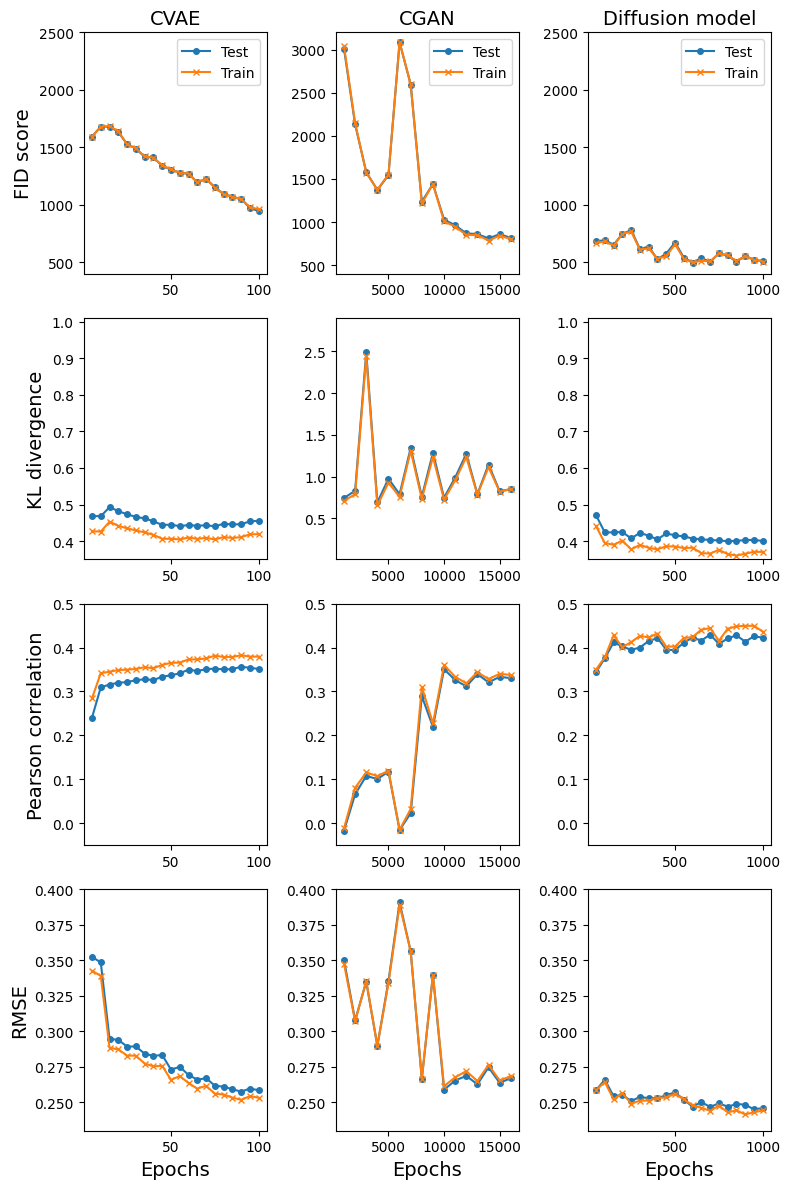

In [ ]:
import matplotlib.pyplot as plt

# Define metrics and models for the plot grid
metrics = ['fid_score', 'kl_divergence', 'pearson_correlation', 'rmse', ]
models = ['CVAE', 'CGAN', 'diffusion_model']

# Create a dictionary to map metric names to their y-axis labels
yaxis_label_map = {'rmse':'RMSE', 'kl_divergence': 'KL divergence', 'pearson_correlation':'Pearson correlation', 'fid_score':'FID score'}

# Initialize a 4x3 grid for the subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(8, 12))

# Nested dictionary to store ymin and ymax values for each metric and model
y_limits = {
    'CGAN': {
        'rmse': {'ymin': 0.23, 'ymax': 0.4},
        'kl_divergence': {'ymin': 0.01, 'ymax': 2.9},
        'pearson_correlation': {'ymin': -0.05, 'ymax': 0.5},
        'fid_score': {'ymin': 400, 'ymax': 3200},
    },
    'CVAE': {
        'rmse': {'ymin': 0.23, 'ymax': 0.4},
        'kl_divergence': {'ymin': 0.35, 'ymax': 1.01},
        'pearson_correlation': {'ymin': -0.05, 'ymax': 0.5},
        'fid_score': {'ymin': 400, 'ymax': 2500},
    },
    'diffusion_model': {
        'rmse': {'ymin': 0.23, 'ymax': 0.4},
        'kl_divergence': {'ymin': 0.35, 'ymax': 1.01},
        'pearson_correlation': {'ymin': -0.05, 'ymax': 0.5},
        'fid_score': {'ymin': 400, 'ymax': 2500},
    }
}

# Loop through rows and columns to create line plots
for i, metric in enumerate(metrics):
    for j, model in enumerate(models):

        # Filter the DataFrame for each model and dataset type
        df_filtered_test = df_metrics[(df_metrics['model'] == model) & (df_metrics['dataset'] == 'test')]
        df_filtered_train = df_metrics[(df_metrics['model'] == model) & (df_metrics['dataset'] == 'train')]

        # Create the line plot for 'test'
        axes[i, j].plot(df_filtered_test['epochs'], df_filtered_test[metric], marker='o', label='Test', markersize=4)

        # Create the line plot for 'train'
        axes[i, j].plot(df_filtered_train['epochs'], df_filtered_train[metric], marker='x', label='Train', markersize=4)

        # Correct the title for the diffusion model
        corrected_model_title = "Diffusion model" if model == "diffusion_model" else model
        #axes[i, j].set_title(corrected_model_title)

        # Correct the y-axis labels
        if i == 0:
          axes[i, j].set_title(corrected_model_title, fontsize=14)


        # Only add y-axis label to the first column
        if j == 0:
            axes[i, j].set_ylabel(yaxis_label_map[metric], fontsize=14)
        else:
            axes[i, j].set_ylabel('')



        # Set manual y-axis limits based on the nested dictionary
        ymin = y_limits[model][metric]['ymin']
        ymax = y_limits[model][metric]['ymax']
        axes[i, j].set_ylim(ymin=ymin, ymax=ymax)

        # Add legend
        #axes[i, j].legend()



        # Add y-axis labels only in the last row
        if i == 3:
          axes[i, j].set_xlabel('Epochs', fontsize=14)

        # Add legend only in the first row
        if i == 0:
            axes[i, j].legend()

# Add super title and layout adjustment
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Adjust the width space to make columns closer
plt.subplots_adjust(wspace=0.3)  # Adjust this value as needed

# Show the plot
plt.tight_layout()
figures_path = "./figures"

# Save the figure to the specified path with 300 dpi resolution
figure_name = "epochs_plots.png"
full_figure_path = os.path.join(figures_path, figure_name)
plt.savefig(full_figure_path, dpi=300, bbox_inches='tight')

# Show the plot
plt.show()